In [1]:
import os
import glob
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyscenic.recovery import aucs as calc_aucs, recovery
from pyscenic.rnkdb import FeatherRankingDatabase as RankingDatabase
from pyscenic.utils import load_motif_annotations
from itertools import repeat
%matplotlib inline

In [2]:
DATA_FOLDER="/Users/bramvandesande/Projects/lcb/tmp"
RESOURCES_FOLDER="/Users/bramvandesande/Projects/lcb/resources"
DATABASE_FOLDER = "/Users/bramvandesande/Projects/lcb/databases/"

SQLITE_GLOB = os.path.join(DATABASE_FOLDER, "mm9-*.db")
FEATHER_GLOB = os.path.join(DATABASE_FOLDER, "mm9-*.feather")

MOTIF_ANNOTATIONS_FNAME = os.path.join(RESOURCES_FOLDER, "motifs-v9-nr.mgi-m0.001-o0.0.tbl")

NOMENCLATURE = "MGI"

In [3]:
with open(os.path.join(DATA_FOLDER,'modules.pickle'), 'rb') as f:
    modules = pickle.load(f)

In [4]:
def name(fname):
    return os.path.basename(fname).split(".")[0]

In [5]:
db_fnames = glob.glob(FEATHER_GLOB)
dbs = [RankingDatabase(fname=fname, name=name(fname), nomenclature="MGI") for fname in db_fnames]

In [6]:
motif_annotations = load_motif_annotations(MOTIF_ANNOTATIONS_FNAME)

#### Assess core methods

In [7]:
total_genes = 100
rank_threshold = 8
ranking = np.asarray([2, 4, 6])
auc_max = 1.0

Correct answer is 12!

In [8]:
auc1d(ranking, rank_threshold, auc_max)

12.0

In [9]:
np.cumsum(np.bincount(np.append(ranking, np.full((1,), total_genes)))[:rank_threshold]).sum() / auc_max

12.0

#### Assess AUCs and NES

In [10]:
COLUMN_NAME_NES = "NES"
COLUMN_NAME_AUC = "AUC"

In [11]:
def impl1(db, module):
    # Load rank of genes from database.
    df = db.load(module)
    features, genes, rankings = df.index.values, df.columns.values, df.values
    
    # Calculate recovery curves, AUC and NES values.
    rccs, aucs = recovery(df, db.total_genes, np.full(len(genes), 1.0), rank_threshold=1500, auc_threshold=0.01)
    ness = (aucs - aucs.mean()) / aucs.std()
    
    enriched_features_idx = ness >= 3.0
    enriched_features = pd.DataFrame(index=pd.MultiIndex.from_tuples(list(zip(repeat(module.transcription_factor),
                                                                              features[enriched_features_idx])),
                                                                     names=["gene_name", "#motif_id"]),
                                     data={COLUMN_NAME_NES: ness[enriched_features_idx],
                                           COLUMN_NAME_AUC: aucs[enriched_features_idx]})
    
    return enriched_features

In [12]:
def impl2(db, module):
    # Load rank of genes from database.
    df = db.load(module)
    features, genes, rankings = df.index.values, df.columns.values, df.values
    
    # Calculate recovery curves, AUC and NES values.
    aucs = calc_aucs(df, db.total_genes, rank_threshold=1500, auc_threshold=0.01)
    ness = (aucs - aucs.mean()) / aucs.std()
    
    enriched_features_idx = ness >= 3.0
    enriched_features = pd.DataFrame(index=pd.MultiIndex.from_tuples(list(zip(repeat(module.transcription_factor),
                                                                              features[enriched_features_idx])),
                                                                     names=["gene_name", "#motif_id"]),
                                     data={COLUMN_NAME_NES: ness[enriched_features_idx],
                                           COLUMN_NAME_AUC: aucs[enriched_features_idx]})
    
    return enriched_features

In [13]:
df1 = impl1(dbs[0], modules[0]).sort_values(by=COLUMN_NAME_NES, ascending=False)

In [14]:
df2 = impl2(dbs[0], modules[0]).sort_values(by=COLUMN_NAME_NES, ascending=False)

In [15]:
df1.head()

AUC       NES
gene_name #motif_id                                 
Aatf      cisbp__M4554            0.013005  5.798997
          transfac_pro__M02068    0.012537  5.407596
          cisbp__M4700            0.012237  5.156698
          transfac_pro__M02065    0.012218  5.141087
          homer__HACTTCCGGY_Elk1  0.012209  5.133281

In [16]:
df2.head()

AUC       NES
gene_name #motif_id                                 
Aatf      cisbp__M4554            0.013005  5.798997
          transfac_pro__M02068    0.012537  5.407596
          cisbp__M4700            0.012237  5.156698
          transfac_pro__M02065    0.012218  5.141087
          homer__HACTTCCGGY_Elk1  0.012209  5.133281

In [17]:
df = pd.merge(df1, df2, how='inner', left_index=True, right_index=True)

In [18]:
df.head()

AUC_x     NES_x     AUC_y     NES_y
gene_name #motif_id                                                     
Aatf      cisbp__M4554            0.013005  5.798997  0.013005  5.798997
          transfac_pro__M02068    0.012537  5.407596  0.012537  5.407596
          cisbp__M4700            0.012237  5.156698  0.012237  5.156698
          transfac_pro__M02065    0.012218  5.141087  0.012218  5.141087
          homer__HACTTCCGGY_Elk1  0.012209  5.133281  0.012209  5.133281

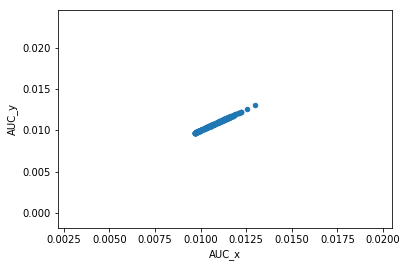

In [19]:
df.plot.scatter(x='AUC_x', y='AUC_y')

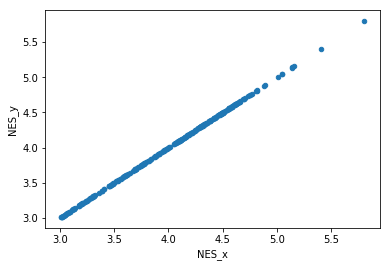

In [20]:
df.plot.scatter(x='NES_x', y='NES_y')

#### Assess regulomes